In [1]:
# Pip install if needed 
# pip install openmeteo-requests

In [2]:
# pip install if needed
# pip install requests-cache retry-requests numpy pandas

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

np.random.seed(42)

In [4]:
weather = pd.read_csv('./data/new-york-weather.csv',header = None)
weather.columns = ['date',"daylight_duration","sunshine_duration","rain_sum","showers_sum",
                   "snowfall_sum","precipitation_hours","wind_speed_10m_max","wind_gusts_10m_max","latitude","longitude"]
weather.shape

C:\Users\graha\AppData\Local\Temp\ipykernel_16540\3871736691.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  weather = pd.read_csv('./data/new-york-weather.csv',header = None)


(288110, 11)

In [5]:
weather = weather.drop(columns = 'showers_sum')

### Drop strings in the dataframe that came from improper appending

In [6]:
weather[weather['daylight_duration'].astype(str).str.contains('day')]

,date,daylight_duration,sunshine_duration,rain_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,latitude,longitude
260028,date,daylight_duration,sunshine_duration,rain_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,latitude,longitude
274669,date,daylight_duration,sunshine_duration,rain_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,latitude,longitude


In [7]:
weather = weather.drop(weather[weather['daylight_duration'].astype(str).str.contains('day')].index)

In [8]:
weather[weather['daylight_duration'].astype(str).str.contains('day')]

,date,daylight_duration,sunshine_duration,rain_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,latitude,longitude


### Sort the dataframe by date

In [9]:
weather = weather.sort_values('date')

### Delete the time in all the dates and remove the white space made

In [10]:
weather['date'] = weather['date'].str.replace('05:00:00+00:00', '')
weather['date'] = weather['date'].str.strip()

In [11]:
weather[["daylight_duration","sunshine_duration","rain_sum",
         "snowfall_sum","precipitation_hours","wind_speed_10m_max","wind_gusts_10m_max","latitude","longitude"]] = weather[["daylight_duration","sunshine_duration","rain_sum",
         "snowfall_sum","precipitation_hours","wind_speed_10m_max","wind_gusts_10m_max","latitude","longitude"]].apply(pd.to_numeric)

In [12]:
weather['precipitation_total'] = weather['rain_sum'] + weather['snowfall_sum'] 
weather['location'] = list(zip(weather['latitude'],weather['longitude']))

In [13]:
# Group by 'location'
grouped = weather.groupby('location')

# Drop duplicates based on 'date' for each group
weather = pd.concat([group.drop_duplicates(subset=['date']) for _, group in grouped], ignore_index=True)

# Display the first few rows of the cleaned DataFrame
weather.shape

(268392, 12)

In [14]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268392 entries, 0 to 268391
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   date                 268392 non-null  object 
 1   daylight_duration    268392 non-null  float64
 2   sunshine_duration    268392 non-null  float64
 3   rain_sum             268392 non-null  float64
 4   snowfall_sum         268392 non-null  float64
 5   precipitation_hours  268392 non-null  float64
 6   wind_speed_10m_max   268392 non-null  float64
 7   wind_gusts_10m_max   268392 non-null  float64
 8   latitude             268392 non-null  float64
 9   longitude            268392 non-null  float64
 10  precipitation_total  268392 non-null  float64
 11  location             268392 non-null  object 
dtypes: float64(10), object(2)
memory usage: 24.6+ MB


In [15]:
weather.isnull().sum()

date                   0
daylight_duration      0
sunshine_duration      0
rain_sum               0
snowfall_sum           0
precipitation_hours    0
wind_speed_10m_max     0
wind_gusts_10m_max     0
latitude               0
longitude              0
precipitation_total    0
location               0
dtype: int64

Make a clustering model with everything 

In [21]:
weather_km = weather.copy()
X = weather_km.drop(columns = ['date','location','rain_sum','snowfall_sum','latitude','longitude'])

pipe_km = Pipeline([
    ('sc', StandardScaler()),
    ('pca',PCA()),
    ('km', KMeans(n_clusters=3))
])

pipe_km.fit(X)


weather_km['cluster'] = pipe_km['km'].labels_
centroids = pipe_km['sc'].inverse_transform(pipe_km['km'].cluster_centers_)


centroids_df = pd.DataFrame(
    centroids,
    columns=X.columns
)

KeyError: 'longitude'

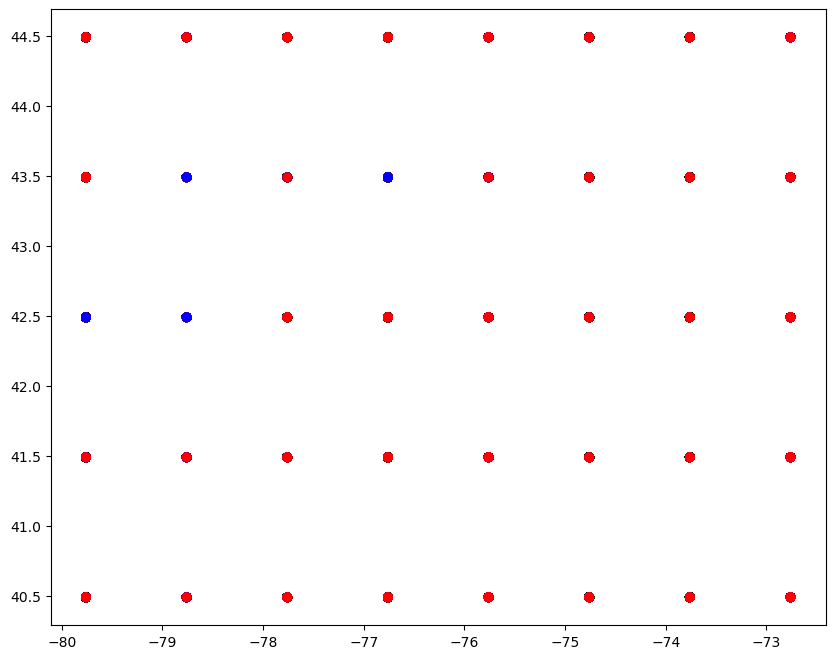

In [22]:
# Define figure size
plt.figure(figsize=(10, 8))

# Map colors for different clusters
colors = ["red", "green", "blue"]
weather_km['color'] = weather_km['cluster'].map(lambda p: colors[p])

# Plot points (spatial data)
plt.scatter(
    weather_km['longitude'], weather_km['latitude'], 
    c=weather_km['color'], 
    label='Data Points'
)

# Plot centroids
plt.scatter(
    centroids_df['longitude'], centroids_df['latitude'], 
    marker="*", 
    c=colors, 
    s=550, 
    edgecolor="k", 
    label='Centroids'
)

# Add labels and legend
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Clusters and Centroids")
plt.legend()
plt.show()



